# Data Augmentation - Copy Paste
##### Author: Kexuan Li
##### Reference: https://github.com/aiLiwensong/Copy-Paste-for-Semantic-Segmentation

In [ ]:
cd

/Users/cocoli


### Create Segementation Mask for Train dataset 

In [ ]:
import os
import cv2
import numpy as np

def create_segmentation_mask(image_path, label_path, mask_save_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file not found: {image_path}")
    height, width, _ = image.shape

    mask = np.zeros((height, width), dtype=np.uint8)

    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split(' '))
            
            x_center, y_center, bbox_width, bbox_height = [x_center * width, y_center * height, bbox_width * width, bbox_height * height]
            top_left_x = int(x_center - (bbox_width / 2))
            top_left_y = int(y_center - (bbox_height / 2))
            bottom_right_x = int(x_center + (bbox_width / 2))
            bottom_right_y = int(y_center + (bbox_height / 2))
            
            cv2.rectangle(mask, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), 255, thickness=-1)

    cv2.imwrite(mask_save_path, mask)

dataset_root = "/Users/cocoli/Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class"

subdirs = {
    "images": {"train": "images/train", "test": "images/test"},
    "labels": {"train": "labels/train", "test": "labels/test"},
    "masks": {"train": "masks/train", "test": "masks/test"},
}

for subset in ["train", "test"]:
    mask_dir_path = os.path.join(dataset_root, subdirs["masks"][subset])
    os.makedirs(mask_dir_path, exist_ok=True)
    
    label_dir_path = os.path.join(dataset_root, subdirs["labels"][subset])
    image_dir_path = os.path.join(dataset_root, subdirs["images"][subset])
    
    for label_file in os.listdir(label_dir_path):
        if label_file.endswith('.txt'):
            base_filename = label_file.replace('.txt', '')
            image_path = os.path.join(image_dir_path, f"{base_filename}.jpg")
            label_path = os.path.join(label_dir_path, f"{base_filename}.txt")
            mask_save_path = os.path.join(mask_dir_path, f"{base_filename}.png")
            
            create_segmentation_mask(image_path, label_path, mask_save_path)


### Copy and Paste Method

In [ ]:
import os
import cv2
import numpy as np
import random

def random_flip_horizontal(image, mask):
    if random.random() < 0.5:
        return np.fliplr(image), np.fliplr(mask)
    return image, mask

def img_add(img_src, img_main, mask_src):
    mask_inv = cv2.bitwise_not(mask_src)
    background = cv2.bitwise_and(img_main, img_main, mask=mask_inv)
    foreground = cv2.bitwise_and(img_src, img_src, mask=mask_src)
    result_img = cv2.add(background, foreground)
    return result_img

def copy_paste(mask_src, img_src, mask_main, img_main):
    mask_src, img_src = random_flip_horizontal(mask_src, img_src)
    mask_main, img_main = random_flip_horizontal(mask_main, img_main)
    combined_img = img_add(img_src, img_main, mask_src)
    combined_mask = img_add(mask_src, mask_main, mask_src)
    return combined_mask, combined_img




### Calculate the normalized bounding box for the new augmented data

In [11]:
def calculate_normalized_bounding_boxes(mask, img_width, img_height):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        xc = (x + w / 2) / img_width
        yc = (y + h / 2) / img_height
        wc = w / img_width
        hc = h / img_height
        bounding_boxes.append((1,xc, yc, wc, hc))
    return bounding_boxes



#### Example case:  Test it on two images 

In [12]:
# background 
main_image_path = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/images/train/00095_236.jpg"
main_mask_path = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/masks/train/00095_236.png"

# source: donor or the image from which elements are taken to be pasted onto the main image
source_image_path = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/images/train/00095_176.jpg"
source_mask_path = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/masks/train/00095_176.png"

img_main = cv2.imread(main_image_path)
mask_main = cv2.imread(main_mask_path, cv2.IMREAD_GRAYSCALE)

img_src = cv2.imread(source_image_path)
mask_src = cv2.imread(source_mask_path, cv2.IMREAD_GRAYSCALE)

if img_main is None or mask_main is None or img_src is None or mask_src is None:
    raise Exception("An image or mask file could not be loaded.")

augmented_mask, augmented_img = copy_paste(mask_src, img_src, mask_main, img_main)


bounding_boxes = calculate_normalized_bounding_boxes(augmented_mask, augmented_img.shape[1], augmented_img.shape[0])
print(bounding_boxes)

# Save the augmented images and masks
output_dir = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class"
os.makedirs(output_dir, exist_ok=True)
output_img_path = os.path.join(output_dir, "augmented_img_test.jpg")
output_mask_path = os.path.join(output_dir, "augmented_mask_test.png")
label_file_path = os.path.join(output_dir, "augmented_labels.txt")
with open(label_file_path, 'w') as file:
    for box in bounding_boxes:
            class_id, xc, yc, wc, hc = box
            file.write(f"{class_id} {xc:.6f} {yc:.6f} {wc:.6f} {hc:.6f}\n")

cv2.imwrite(output_img_path, augmented_img)
cv2.imwrite(output_mask_path, augmented_mask)



[(1, 0.390625, 0.3837890625, 0.08203125, 0.076171875), (1, 0.556640625, 0.373046875, 0.14453125, 0.1953125)]


True

#### Display images 

(-0.5, 511.5, 511.5, -0.5)

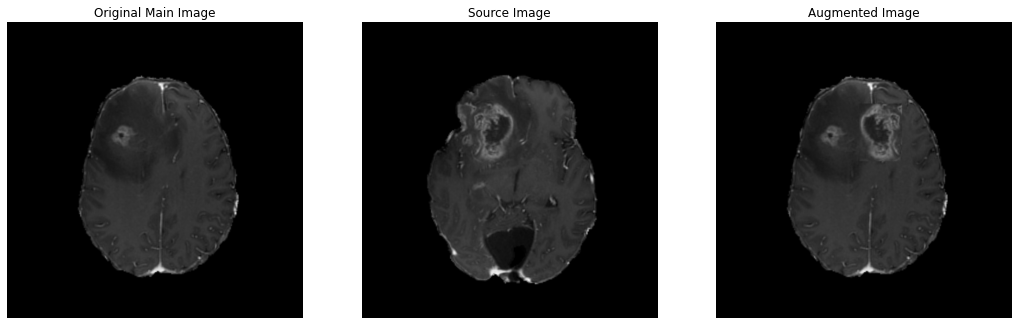

In [15]:

plt.figure(figsize=(18, 6))  # Adjust the size as needed

plt.subplot(1, 3, 1) 
plt.imshow(cv2.cvtColor(img_main, cv2.COLOR_BGR2RGB))
plt.title("Original Main Image")
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Source Image")
plt.axis('off')

plt.subplot(1, 3, 3)  
plt.imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
plt.title("Augmented Image")
plt.axis('off')

#### Test to see if the new augmented lable are correct

In [21]:
import cv2
import numpy as np

def draw_bounding_boxes(image, boxes):
    """
    Draw bounding boxes on an image.
    Boxes are a list of tuples (x_center, y_center, width, height) normalized to the image size.
    """
    img = image.copy()
    h, w = img.shape[:2]
    for (num,xc, yc, wc, hc) in boxes:
      
        x1 = int((xc - wc / 2) * w)
        y1 = int((yc - hc / 2) * h)
        x2 = int((xc + wc / 2) * w)
        y2 = int((yc + hc / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img


In [22]:
# Load the image
augmented_img = cv2.imread('Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented_img_test.jpg')

bounding_boxes = calculate_normalized_bounding_boxes(augmented_mask, augmented_img.shape[1], augmented_img.shape[0])

visualized_image = draw_bounding_boxes(augmented_img, bounding_boxes)

output_visualized_path = 'Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/visualized_augmented_img_test.jpg'

# Save the visualized image
cv2.imwrite(output_visualized_path, visualized_image)


True

(-0.5, 511.5, 511.5, -0.5)

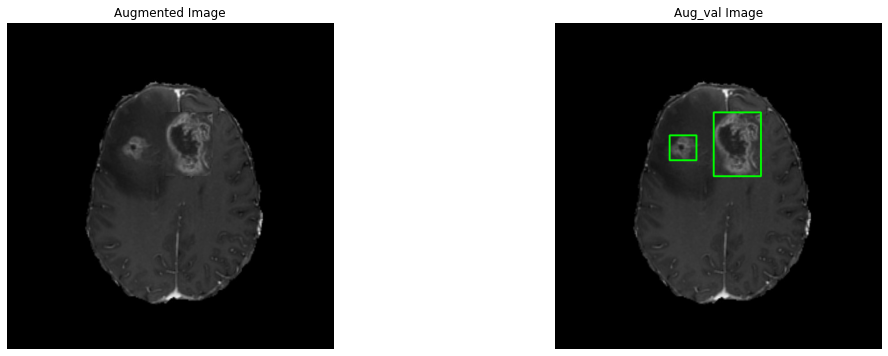

In [23]:
# Display: 
plt.figure(figsize=(18, 6))  # Adjust the size as needed

plt.subplot(1, 2, 1) 
plt.imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
plt.title("Augmented Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(cv2.cvtColor(visualized_image, cv2.COLOR_BGR2RGB))
plt.title("Aug_val Image")
plt.axis('off')


#### Helper function

In [24]:

def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

def load_images_and_masks(image_dir, mask_dir):
    images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    masks = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')]
    return images, masks

def get_corresponding_image_path(mask_path, image_dir):
    # Convert mask filename to image filename
    base_filename = os.path.basename(mask_path).replace('.png', '.jpg')
    image_path = os.path.join(image_dir, base_filename)
    return image_path


#### Generalized for the whole dataset

In [25]:
import os
import cv2
import numpy as np
import random


def augment_images(image_dir, mask_dir, output_dir, num_augmentations=100):
    ensure_dir(output_dir)
    images, masks = load_images_and_masks(image_dir, mask_dir)
    output_image_dir = os.path.join(output_dir, 'images')
    output_mask_dir = os.path.join(output_dir, 'masks')
    output_label_dir=os.path.join(output_dir, 'labels')
    output_check_dir=os.path.join(output_dir, 'check')
    ensure_dir(output_image_dir)
    ensure_dir(output_mask_dir)
    ensure_dir(output_label_dir)
    ensure_dir(output_check_dir)

    successful_augmentations = 0
    while successful_augmentations < num_augmentations:
        mask_path = random.choice(masks)
        image_path = get_corresponding_image_path(mask_path, image_dir)
        img_main = cv2.imread(image_path)
        mask_main = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img_main is None or mask_main is None:
            continue  

        other_mask_path = random.choice([x for x in masks if x != mask_path])
        mask_src = cv2.imread(other_mask_path, cv2.IMREAD_GRAYSCALE)
        other_image_path=get_corresponding_image_path(other_mask_path, image_dir)
        img_src=cv2.imread(other_image_path)
        
     
        if img_src is None or mask_src is None or img_src.shape != img_main.shape:
            continue  

        augmented_mask, augmented_img = copy_paste(mask_src, img_src, mask_main, img_main)
        bounding_boxes = calculate_normalized_bounding_boxes(augmented_mask, augmented_img.shape[1], augmented_img.shape[0])
    
        if len(bounding_boxes)==2:
            output_img_path = os.path.join(output_image_dir, f"augmented_img_{successful_augmentations}.jpg")
            output_mask_path = os.path.join(output_mask_dir, f"augmented_mask_{successful_augmentations}.png")
            output_label_path =os.path.join(output_label_dir, f"augmented_mask_{successful_augmentations}.txt")
            with open(output_label_path, 'w') as file:
                for (class_id,xc, yc, wc, hc) in bounding_boxes:
                    file.write(f"{class_id} {xc:.6f} {yc:.6f} {wc:.6f} {hc:.6f}\n")  
            cv2.imwrite(output_img_path, augmented_img)
            cv2.imwrite(output_mask_path, augmented_mask)
            visualized_image = draw_bounding_boxes(augmented_img, bounding_boxes)
            output_visualized_path = os.path.join(output_check_dir, f"augmented_mask_{successful_augmentations}.jpg")
            cv2.imwrite(output_visualized_path, visualized_image)

            
        
            successful_augmentations += 1

                    
        else:
            continue 
  
        

    print(f"Generated {successful_augmentations} augmented images.")

image_dir = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/images/train"
mask_dir = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/masks/train"
output_dir = "Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented_new"


augment_images(image_dir, mask_dir, output_dir, num_augmentations=150)


Generated 150 augmented images.


### Creat Labels

In [3]:
import os

# Set the paths for your images and labels directories
images_directory = os.path.expanduser('~/Desktop/notumor')
labels_directory = os.path.expanduser('~/Desktop/labels')

# Make sure the labels directory exists, create if it doesn't
os.makedirs(labels_directory, exist_ok=True)

# List all files in the images directory
image_files = os.listdir(images_directory)

# Loop over the image files to create corresponding label files
for image_file in image_files:
    if image_file.endswith('.jpg'):
        # Construct the full path to the new label file
        label_file_path = os.path.join(labels_directory, image_file.replace('.jpg', '.txt'))
        
        # Create an empty .txt file
        open(label_file_path, 'w').close()

print("Label files created successfully.")


Label files created successfully.


### Rename Files

In [26]:
import os

def rename_files(directory, old_part, new_part, file_extension):
    """
    Renames files in the specified directory by replacing part of the filename.
    """
    for filename in os.listdir(directory):
        if filename.endswith(file_extension):
            # Replace the specified part of the filename
            new_filename = filename.replace(old_part, new_part)
            # Rename the file
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
    print(f"Files in {directory} have been renamed from {old_part} to {new_part}.")

# Paths to the image and label directories
image_directory = os.path.expanduser('~/Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented/images')
label_directory = os.path.expanduser('~/Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented/labels')

# Rename image files by removing 'img' and replace it with 'augmented_'
rename_files(image_directory, 'img_', 'augmented_', '.jpg')
# Rename label files by removing 'label' and replace it with 'augmented_'
rename_files(label_directory, 'label_', 'augmented_', '.txt')

print("Renaming complete. Files in both directories now have consistent naming.")


Files in /Users/cocoli/Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented/images have been renamed from img_ to augmented_.
Files in /Users/cocoli/Desktop/Biomedical/rcs yolo data to use/axial_t1wce_2_class/augmented/labels have been renamed from label_ to augmented_.
Renaming complete. Files in both directories now have consistent naming.
